In [1]:
import time

import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.svm import LinearSVR as SklearnLinearSVR

from concrete.ml.sklearn.svm import LinearSVR as ConcreteLinearSVR

/mnt/c/Users/kingo/Desktop/MIT2023-24/6.5610/65610_project/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 7.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 8.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.5 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 KB 7.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 7.9 MB/s eta 0:00:00a 0:00:01


In [4]:
import matplotlib.pyplot as plt
from IPython.display import display

train_plot_config = {"c": "black", "marker": "D", "s": 15, "label": "Train data"}
test_plot_config = {"c": "red", "marker": "x", "s": 15, "label": "Test data"}


def get_sklearn_plot_config(mse_score=None):
    label = "scikit-learn"
    if mse_score is not None:
        label += f", {''}={mse_score:.4f}"
    return {"c": "blue", "linewidth": 2.5, "label": label}


def get_concrete_plot_config(mse_score=None):
    label = "Concrete-ML"
    if mse_score is not None:
        label += f", {''}={mse_score:.4f}"
    return {"c": "orange", "linewidth": 2.5, "label": label}

In [5]:
#  Load the diabetes data-set
X, y = load_diabetes(return_X_y=True)
# Use only one feature for educational purpose
X = X[:, np.newaxis, 2]

# We split the data-set into a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=23)

# We sort the test set for a better visualization
sorted_indexes = np.argsort(np.squeeze(X_test))
X_test = X_test[sorted_indexes, :]
y_test = y_test[sorted_indexes]

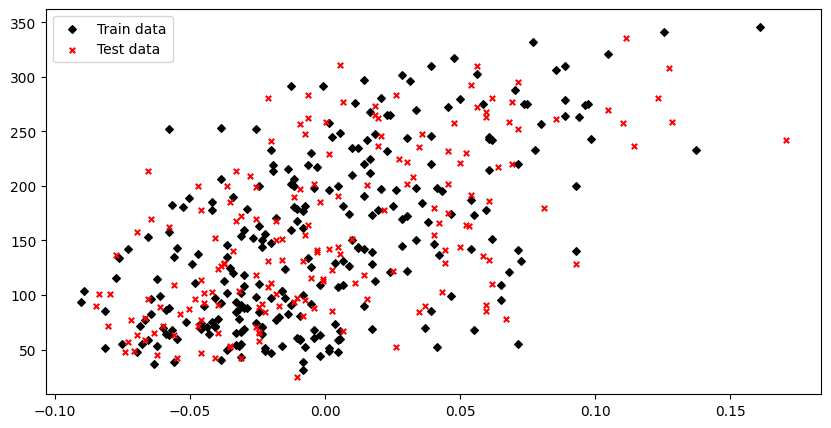

<Figure size 640x480 with 0 Axes>

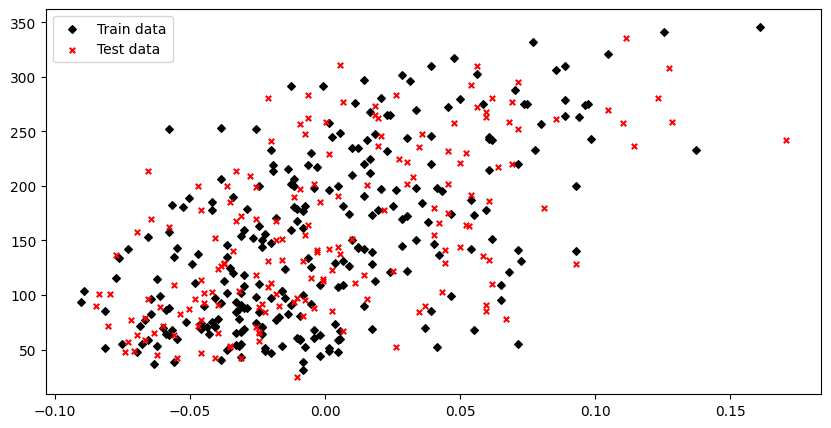

In [6]:
plt.ioff()

plt.clf()
fig, ax = plt.subplots(1, figsize=(10, 5))
fig.patch.set_facecolor("white")
ax.scatter(X_train, y_train, **train_plot_config)
ax.scatter(X_test, y_test, **test_plot_config)
ax.legend()
display(fig)

In [7]:
grid_scorer = make_scorer(mean_squared_error, greater_is_better=False)


In [8]:
param_grid = {
    "epsilon": [0.0, 1.0, 10.0, 20.0],
    "C": [0.1, 100.0, 10000.0, 100000.0],
}

sklearn_rgs = SklearnLinearSVR()
kfold_cv = KFold(n_splits=5, shuffle=True, random_state=13)

gs_sklearn = GridSearchCV(
    sklearn_rgs,
    param_grid,
    cv=kfold_cv,
    scoring=grid_scorer,
    verbose=1,
).fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [9]:
param_grid = {
    "n_bits": [6, 8, 12],
    "epsilon": [0.0, 1.0, 10.0, 20.0],
    "C": [0.1, 100.0, 10000.0, 100000.0],
}

concrete_rgs = ConcreteLinearSVR()

gs_concrete = GridSearchCV(
    concrete_rgs,
    param_grid,
    cv=kfold_cv,
    scoring=grid_scorer,
    verbose=1,
).fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


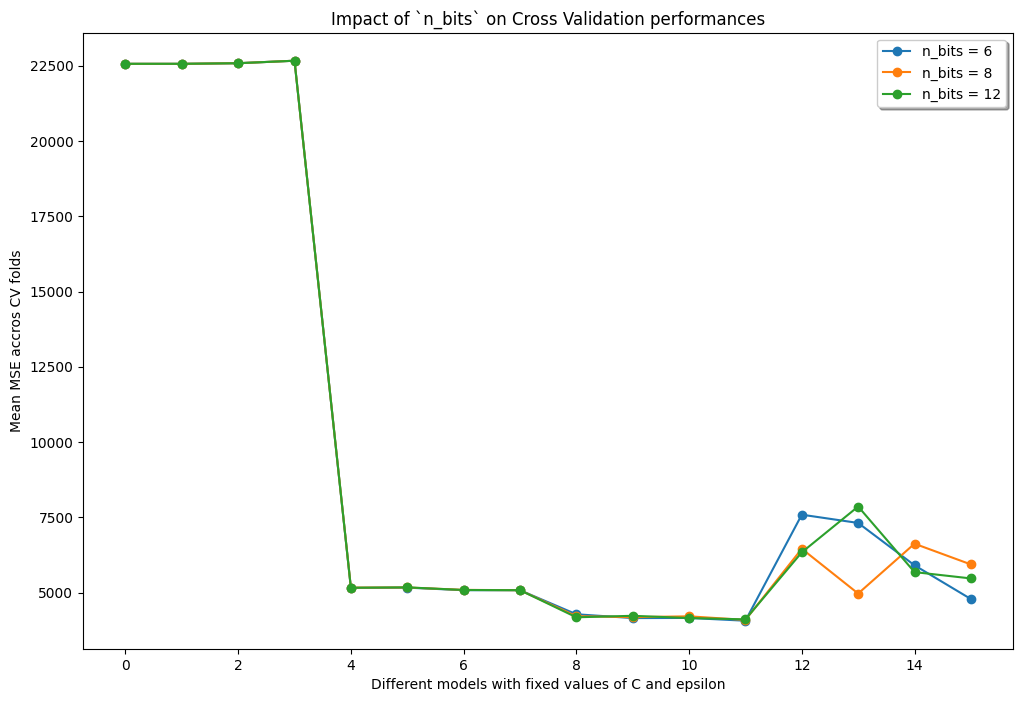

In [10]:
plt.ioff()

results_df = pd.DataFrame(gs_concrete.cv_results_)

fig, ax = plt.subplots(1, figsize=(12, 8))
(l1,) = ax.plot(
    np.arange(16), -results_df.loc[results_df["param_n_bits"] == 6, "mean_test_score"], "-o"
)
(l2,) = ax.plot(
    np.arange(16), -results_df.loc[results_df["param_n_bits"] == 8, "mean_test_score"], "-o"
)
(l3,) = ax.plot(
    np.arange(16), -results_df.loc[results_df["param_n_bits"] == 12, "mean_test_score"], "-o"
)
ax.legend((l1, l2, l3), ("n_bits = 6", "n_bits = 8", "n_bits = 12"), loc="upper right", shadow=True)
ax.set_xlabel("Different models with fixed values of C and epsilon")
ax.set_ylabel("Mean MSE accros CV folds")
ax.set_title("Impact of `n_bits` on Cross Validation performances")
display(fig)

In [11]:
# Print mean time fit and std time fit for both models
print(
    f"Mean time fit sklearn: {np.mean(gs_sklearn.cv_results_['mean_fit_time']):.3f}s,"
    f" std time fit sklearn: {np.std(gs_sklearn.cv_results_['mean_fit_time']):.3f}s"
)
print(
    f"Mean time fit concrete: {np.mean(gs_concrete.cv_results_['mean_fit_time']):.3f}s,"
    f"std time fit concrete: {np.std(gs_concrete.cv_results_['mean_fit_time']):.3f}s"
)

# Print best score for both models
print(f"Best MSE score sklearn: {-gs_sklearn.best_score_:.2f}")
print(f"Best MSE score concrete: {-gs_concrete.best_score_:.2f}")

Mean time fit sklearn: 0.002s, std time fit sklearn: 0.002s
Mean time fit concrete: 1.205s,std time fit concrete: 0.329s
Best MSE score sklearn: 4079.22
Best MSE score concrete: 4065.40


In [12]:
# Get best hyperparameters out of gs_concrete
best_params_concrete = gs_concrete.best_params_
print(f"Best parameters for Concrete: {best_params_concrete}")
best_params_sklearn = gs_sklearn.best_params_
print(f"Best parameters for Sklearn: {best_params_sklearn}")

Best parameters for Concrete: {'C': 10000.0, 'epsilon': 20.0, 'n_bits': 6}
Best parameters for Sklearn: {'C': 10000.0, 'epsilon': 20.0}


In [13]:
# Train concrete and sklearn LinearSVR with best hyper parameters
concrete_rgs = ConcreteLinearSVR(**best_params_concrete)

concrete_rgs, sklearn_rgs = concrete_rgs.fit_benchmark(X_train, y_train)

In [14]:
# Compile the model using the training data
# print(concrete_rgs.compile.__code__.co_varnames)
circuit = concrete_rgs.compile(X = X_train)

In [15]:
print(f"Generating a key for an {circuit.graph.maximum_integer_bit_width()}-bit circuit")


Generating a key for an 7-bit circuit


In [16]:
time_begin = time.time()
circuit.client.keygen(force=False)
print(f"Key generation time: {time.time() - time_begin:.2f} seconds")

Key generation time: 0.08 seconds


In [17]:
# Now predict using the FHE-quantized model on the testing set
time_begin = time.time()
y_pred_fhe = concrete_rgs.predict(X_test, fhe="execute")
print(f"Execution time: {(time.time() - time_begin) / len(X_test):.4f} seconds per sample")

# Now predict using the Sklearn model on the testing set
time_begin = time.time()
y_pred_sklearn = sklearn_rgs.predict(X_test)
print(f"Execution time: {(time.time() - time_begin) / len(X_test):.4f} seconds per sample")

# Now predict using clear quantized Concrete-ML model on testing set
time_begin = time.time()
y_preds_quantized = concrete_rgs.predict(X_test)
print(f"Execution time: {(time.time() - time_begin) / len(X_test):.4f} seconds per sample")

Execution time: 0.0052 seconds per sample
Execution time: 0.0000 seconds per sample
Execution time: 0.0000 seconds per sample


In [18]:
# We densify the space representation of the original X,
# to better visualize the resulting step function in the following figure
x_space = np.linspace(X_test.min(), X_test.max(), num=300)
x_space = x_space[:, np.newaxis]
y_pred_q_space = concrete_rgs.predict(x_space)